In [2]:
# Torch
import torch
from torch_geometric.data import DataLoader
from torch_geometric.loader import DataLoader

from torch_geometric.nn import SAGEConv, DenseSAGEConv, GATConv, HeteroConv, Linear
from torch_geometric.nn import aggr

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

# Misc
import os
import time
from math import ceil
import random
from IPython.display import clear_output


# Torch and CUDA options
torch.manual_seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Path constants
PATH_GRAPH_DATA = '../../data/matches-processed/cs2/hetero-graph/'
PATH_MODELS = '../../model/gnn/'

# Training of Heterogeneous GNN

This notebook contains the code for the heterogeneous GNN training on pytorch graph dataset. 

----
## Data load

Load the data

### Training data

In [2]:
hetero_data = torch.load('./temp_data/train_0-40.pt')

C:\Users\szmid\AppData\Local\Temp\ipykernel_8952\2648833315.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hetero_data = torch.load('./temp_data/train_0-40.pt')


In [85]:
# Initialize hetero_data list
hetero_data = torch.load(PATH_GRAPH_DATA + '100000.pt', weights_only=False)
random.shuffle(hetero_data)
hetero_data = hetero_data[:1000]
hetero_data_index = 100001

for idx in range(40):
    temp = torch.load(PATH_GRAPH_DATA + str(hetero_data_index + idx) + '.pt', weights_only=False)
    random.shuffle(temp)
    hetero_data = hetero_data + temp[:1000]

ct_wins = 0
for data in hetero_data:
    ct_wins += data.y['CT_wins']

print('CT wins %:', ct_wins / len(hetero_data))

CT wins %: 0.4140243902439024


In [86]:
torch.save(hetero_data, './_/train_0-40.pt')

### Validation data

In [3]:
val_data = torch.load('./temp_data/val_50-60.pt')

C:\Users\szmid\AppData\Local\Temp\ipykernel_8952\1762845919.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_data = torch.load('./temp_data/val_50-60.pt')


In [87]:
val_data = torch.load(PATH_GRAPH_DATA + '100050.pt', weights_only=False)
random.shuffle(val_data)
val_data = val_data[:2000]
val_data_index = 100051

for idx in range(10):
    temp = torch.load(PATH_GRAPH_DATA + str(val_data_index + idx) + '.pt', weights_only=False)
    random.shuffle(temp)
    val_data = val_data + temp[:2000]

ct_wins_val = 0
for data in val_data:
    ct_wins_val += data.y['CT_wins']

print('CT wins %:', ct_wins_val / len(hetero_data))

CT wins %: 0.21829268292682927


In [88]:
torch.save(val_data, './_/val_50-60.pt')

----
## Heterogeneous GNN

In this section, the heterogeneous GNN model is defined as well as the essentials for the training process, including data loaders, loss metrics, optimizer, the training / validation / test functions along with the plotting one to make interpretation easy.

In [3]:
class HeterogeneousGNN(torch.nn.Module):

    # --------------------------------------------------
    # Initialization
    # --------------------------------------------------

    def __init__(self, player_dims, map_dims, dense_layers):

        super().__init__()

        self.conv_layer_number = max([len(player_dims), len(map_dims)])
        self.player_convs = len(player_dims)
        self.map_convs = len(map_dims)

        # Create convolutional layers
        self.convs = torch.nn.ModuleList()
        for conv_idx in range(self.conv_layer_number):

            layer_config = {}

            if conv_idx < len(player_dims):
                layer_config[('player', 'is', 'player')] = GATConv((-1, -1), player_dims[conv_idx], add_self_loops=False)

            if conv_idx < len(player_dims):
                layer_config[('player', 'closest_to', 'map')] = GATConv((-1, -1), map_dims[conv_idx], add_self_loops=False)

            if conv_idx < len(map_dims):
                layer_config[('map', 'connected_to', 'map')] = GATConv((-1, -1), map_dims[conv_idx], add_self_loops=False)

            conv = HeteroConv(layer_config, aggr='mean')
            self.convs.append(conv)



        # Create linear layer for the flattened input
        self.linear = Linear(-1, dense_layers[0]['input_neuron_num'])

        
        # Create dense layers based on the 'dense_layers' parameter
        dense_layers_container = []
        for layer_config in dense_layers:

            if layer_config['dropout'] == 0:
                # Add the first layer manually because it has a different input size
                dense_layers_container.append(torch.nn.Linear(layer_config['input_neuron_num'], layer_config['neuron_num']))
                
                # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                if layer_config['activation_function'] is not None:
                    dense_layers_container.append(layer_config['activation_function'])

                # Add the rest of the layers (if there are any)
                for _ in range(layer_config['num_of_layers'] - 1):
                    dense_layers_container.append(torch.nn.Linear(layer_config['neuron_num'], layer_config['neuron_num']))

                    # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                    if layer_config['activation_function'] is not None:
                        dense_layers_container.append(layer_config['activation_function'])
            else:
                dense_layers_container.append(torch.nn.Dropout(layer_config['dropout']))
        
        self.dense = torch.nn.Sequential(*dense_layers_container)
        





    # --------------------------------------------------
    # Forward pass
    # --------------------------------------------------

    def forward(self, x_dict, edge_index_dict, y, batch_size):

        # Do the convolutions
        conv_idx = 1
        for conv in self.convs:
            temp = conv(x_dict, edge_index_dict)
            
            if conv_idx < self.player_convs:
                x_dict['player'] = temp['player']

            if conv_idx < self.map_convs:
                x_dict['map'] = temp['map']
                
            x_dict = {key: x.relu() for key, x in x_dict.items()}

            conv_idx += 1


        # Container for the flattened graphs after the convolutions
        flattened_graphs = []

        # Do the convolutions for each graph in the batch
        for graph_idx in range(batch_size):

            # Get the actual graph
            actual_x_dict, actual_edge_index_dict = self.get_actual_graph(x_dict, edge_index_dict, graph_idx, batch_size)

            # Get the graph data
            graph_data = torch.tensor([
                y['round'][graph_idx],
                y['time'][graph_idx],
                y['remaining_time'][graph_idx],
                y['CT_alive_num'][graph_idx],
                y['T_alive_num'][graph_idx],
                y['CT_total_hp'][graph_idx],
                y['T_total_hp'][graph_idx],
                y['CT_equipment_value'][graph_idx],
                y['T_equipment_value'][graph_idx],
                y['CT_losing_streak'][graph_idx],
                y['T_losing_streak'][graph_idx],
                y['is_bomb_dropped'][graph_idx],
                y['is_bomb_being_planted'][graph_idx],
                y['is_bomb_being_defused'][graph_idx],
                y['is_bomb_planted_at_A_site'][graph_idx],
                y['is_bomb_planted_at_B_site'][graph_idx],
                y['bomb_X'][graph_idx],
                y['bomb_Y'][graph_idx],
                y['bomb_Z'][graph_idx],
                y['bomb_mx_pos1'][graph_idx],
                y['bomb_mx_pos2'][graph_idx],
                y['bomb_mx_pos3'][graph_idx],
                y['bomb_mx_pos4'][graph_idx],
                y['bomb_mx_pos5'][graph_idx],
                y['bomb_mx_pos6'][graph_idx],
                y['bomb_mx_pos7'][graph_idx],
                y['bomb_mx_pos8'][graph_idx],
                y['bomb_mx_pos9'][graph_idx],
            ]).to('cuda')

            # Create the flattened input tensor and append it to the container
            x = torch.cat([torch.flatten(actual_x_dict['player']), torch.flatten(actual_x_dict['map']), torch.flatten(graph_data)])

            flattened_graphs.append(x)

        # Stack the flattened graphs
        x = torch.stack(flattened_graphs).to('cuda')

        x = self.linear(x)
        x = torch.nn.functional.leaky_relu(x)
        
        x = self.dense(x)
        
        return x
    






    # --------------------------------------------------
    # Helper functions
    # --------------------------------------------------

    def get_actual_graph(self, x_dict, edge_index_dict, graph_idx, batch_size):

        # Node feature dictionary for the actual graph
        actual_x_dict = {}

        single_player_node_size = int(x_dict['player'].shape[0] / batch_size)
        single_map_node_size = int(x_dict['map'].shape[0] / batch_size)

        actual_x_dict['player'] = x_dict['player'][graph_idx*single_player_node_size:(graph_idx+1)*single_player_node_size, :]
        actual_x_dict['map'] = x_dict['map'][graph_idx*single_map_node_size:(graph_idx+1)*single_map_node_size, :]


        # Edge index dictionary for the actual graph
        actual_edge_index_dict = {}

        single_map_to_map_edge_size = int(edge_index_dict[('map', 'connected_to', 'map')].shape[1] / batch_size)
        single_player_to_map_edge_size = int(edge_index_dict[('player', 'closest_to', 'map')].shape[1] / batch_size)

        actual_edge_index_dict[('map', 'connected_to', 'map')] = edge_index_dict[('map', 'connected_to', 'map')] \
            [:, graph_idx*single_map_to_map_edge_size:(graph_idx+1)*single_map_to_map_edge_size] \
            - graph_idx*single_map_node_size
        
        actual_edge_index_dict[('player', 'closest_to', 'map')] = edge_index_dict[('player', 'closest_to', 'map')] \
            [:, graph_idx*single_player_to_map_edge_size:(graph_idx+1)*single_player_to_map_edge_size]
        
        actual_edge_index_dict_correction_tensor = torch.tensor([single_player_node_size*graph_idx, single_map_node_size*graph_idx]).to('cuda')
        actual_edge_index_dict[('player', 'closest_to', 'map')] = actual_edge_index_dict[('player', 'closest_to', 'map')] - actual_edge_index_dict_correction_tensor.view(-1, 1)

        
        return actual_x_dict, actual_edge_index_dict
    


In [49]:
batch_size = 64

train_loader = DataLoader(hetero_data[:6400], batch_size=batch_size, shuffle=False)
val_loader = DataLoader(hetero_data[6400:9600], batch_size=batch_size, shuffle=False)

dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 512,
        "input_neuron_num": 512,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 128,
        "input_neuron_num": 512,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.2,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 16,
        "input_neuron_num": 128,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 4,
        "input_neuron_num": 16,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1,
        "input_neuron_num": 4,
        "activation_function": None
    },
]

model = HeterogeneousGNN(player_dims=[100, 50, 25], map_dims=[20, 15, 10, 5], dense_layers=dense_layers).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.02)
loss_function = torch.nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch in train_loader:

        batch = batch.to('cuda')

        out = model(batch.x_dict, batch.edge_index_dict, batch.y, batch_size)
        out = torch.sigmoid(out)
        print(out)
        break


     
print('params:', sum(p.numel() for p in model.parameters()))
print('trainable:', sum(p.numel() for p in model.parameters() if p.requires_grad))

tensor([[0.3794],
        [0.3866],
        [0.3892],
        [0.3907],
        [0.4035],
        [0.3800],
        [0.3878],
        [0.3854],
        [0.3875],
        [0.3951],
        [0.3929],
        [0.3970],
        [0.3761],
        [0.3870],
        [0.3775],
        [0.3894],
        [0.3871],
        [0.4023],
        [0.3766],
        [0.4034],
        [0.4070],
        [0.3842],
        [0.4033],
        [0.3957],
        [0.3837],
        [0.3812],
        [0.3854],
        [0.3749],
        [0.3821],
        [0.3975],
        [0.4075],
        [0.3985],
        [0.3976],
        [0.3922],
        [0.4002],
        [0.3995],
        [0.4094],
        [0.3991],
        [0.3967],
        [0.3982],
        [0.4020],
        [0.3951],
        [0.3924],
        [0.3824],
        [0.3883],
        [0.3974],
        [0.3796],
        [0.4022],
        [0.3863],
        [0.3982],
        [0.3892],
        [0.3930],
        [0.4181],
        [0.4095],
        [0.3972],
        [0

In [8]:
def epoch_result_visualization(
    epochs,
    epoch,
    epoch_start,
    epoch_start_time,
    epoch_end,
    epoch_end_time,
    predictions,
    train_avg_loss,
    val_metrics,
    train_losses,
    val_losses, 
    accuracies, 
    precisions, 
    recalls, 
    f1_scores
):
    clear_output(wait=True)

    val_avg_loss = val_metrics[0]
    accuracy = val_metrics[1]
    precision = val_metrics[2]
    recall = val_metrics[3]
    f1 = val_metrics[4]
    cm = val_metrics[5]
    cm_normalized = val_metrics[6]
    fpr, tpr = val_metrics[7], val_metrics[8]

    predictions = [pred[0] for pred in predictions]
    predictions = np.sort(predictions)

    print("-------------------------------------------------------------------------------------------\n"
         f"                                     Epoch {epoch}\n"
          "-------------------------------------------------------------------------------------------\n"
          "Time: \n"
         f"   -Start time: {epoch_start_time} \n"
         f"   -End time: {epoch_end_time}s \n"
         f"   -Duration: {epoch_end - epoch_start}s \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Training results:\n"
         f"   - Average loss: {train_avg_loss:.4f} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Validation results: \n"
         f"   - Average loss: {val_avg_loss} \n"
         f"   - Accuracy: {accuracy} \n"
         f"   - Precision: {precision} \n"
         f"   - Recall: {recall} \n"
         f"   - F1: {f1} \n"
          "   - Confusion matrix & ROC/AUC\n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")
    
    # ----------------------------------------
    # Confusion matrix & ROC/AUC & Calibration visualization
    # ----------------------------------------

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle(f'Epoch {epoch} - Validation scores', fontsize=12)


    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    # Add numbers to the confusion matrix
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # ROC/AUC Curve
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc(fpr, tpr))
    axs[1].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate', fontsize=8)
    axs[1].set_ylabel('True Positive Rate', fontsize=8)
    axs[1].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[1].legend(loc="lower right", fontsize=8)
    axs[1].set_aspect('equal')

    # Model calibration plot
    axs[2].plot(np.linspace(1, len(predictions), len(predictions)), predictions, lw=2)
    axs[2].set_ylim([0.0, 1.0])
    axs[2].plot([0, len(predictions)], [0, 1], color='black', lw=1, linestyle='--')
    axs[2].set_xlabel('Samples', fontsize=8)
    axs[2].set_ylabel('Predicted Proba', fontsize=8)
    axs[2].set_title('Calibration curve', fontsize=10, y=1)
    axs[2].set_aspect('auto')



    plt.tight_layout()
    plt.show()



    # ----------------------------------------
    # Metrics visualization
    # ----------------------------------------

    fig, axs = plt.subplots(2, 3, figsize=(8, 4.5))
    fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=12)

    epochs_range = np.arange(0, epoch + 1)

    def plot_metric(ax, data, title, ylabel, color):
        if len(data) == 1:
            ax.scatter(epochs_range, data, s=10, c=color)
        else:
            ax.plot(epochs_range, data, marker='o', linestyle='-', color=color)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Epoch', fontsize=8)
        ax.set_ylabel(ylabel, fontsize=8)
        ax.set_xticks(epochs_range)
        ax.set_xlim(-1, epochs)
        if 'Loss' not in title:
            ax.set_ylim(0, 1)
        ax.grid(True)

    plot_metric(axs[0, 0], train_losses, 'Train Loss', 'Loss', 'cornflowerblue')
    plot_metric(axs[0, 1], val_losses, 'Validation Loss', 'Loss', 'darkorange')
    plot_metric(axs[0, 2], accuracies, 'Accuracy', 'Accuracy', 'limegreen')
    plot_metric(axs[1, 0], precisions, 'Precision', 'Precision', 'red')
    plot_metric(axs[1, 1], recalls, 'Recall', 'Recall', 'teal')
    plot_metric(axs[1, 2], f1_scores, 'F1 Score', 'F1 Score', 'black')

    plt.tight_layout()
    plt.show()



def train(model, train_loader, val_loader, batch_size, epochs):

    torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for epoch in range(epochs):

        epoch_start = time.time()
        epoch_start_time = time.asctime(time.localtime()) 
        model.train()
        total_loss = 0
        
        for data in train_loader:  # Iterate in batches over the training dataset.
            data = data.to('cuda')
            optimizer.zero_grad()  # Clear gradients.
            
            out = model(data.x_dict, data.edge_index_dict, data.y, batch_size).float()  # Perform a single forward pass.
            target = torch.tensor(data.y['CT_wins']).float().to('cuda')  # Assuming target is stored in data.y

            loss = loss_function(out.squeeze(), target)  # Compute the loss.
            loss.backward()  # Backpropagate.
            optimizer.step()  # Update model parameters.

            total_loss += loss.item()  # Accumulate the loss.


        train_avg_loss = total_loss / len(train_loader)
        val_metrics = validation(val_loader, batch_size)  # Validate the model on validation dataset.
        epoch_end = time.time()
        epoch_end_time = time.asctime(time.localtime()) 

        val_avg_loss = val_metrics[0]
        accuracy = val_metrics[1]
        precision = val_metrics[2]
        recall = val_metrics[3]
        f1 = val_metrics[4]

        train_losses.append(train_avg_loss)
        val_losses.append(val_avg_loss)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        epoch_result_visualization(epochs, epoch, epoch_start, epoch_start_time, epoch_end, epoch_end_time, val_metrics[9], train_avg_loss, val_metrics, train_losses, val_losses, accuracies, precisions, recalls, f1_scores)

        

def validation(val_loader, batch_size):
    model.eval()  # Switch to evaluation mode.
    total_loss = 0
    total_samples = 0
    predictions_all = []
    targets_all = []

    with torch.no_grad():
        for data in val_loader:  # Iterate in batches over the validation dataset.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y, batch_size).float()
            target = torch.tensor(data.y['CT_wins']).float().to('cuda')

            loss = loss_function(out.squeeze(), target)
            total_loss += loss.item()
            total_samples += len(target)

            # Get the predictions
            predictions = torch.sigmoid(out).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Calculate performance metrics
    sorted_predictions = np.sort(predictions_all).tolist()
    rounded_predictions = np.round(predictions_all)
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(targets_all, rounded_predictions)
    precision = precision_score(targets_all, rounded_predictions)
    recall = recall_score(targets_all, rounded_predictions)
    f1 = f1_score(targets_all, rounded_predictions)
    cm = confusion_matrix(targets_all, rounded_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    return avg_loss, accuracy, precision, recall, f1, cm, cm_normalized, fpr, tpr, sorted_predictions



def test(test_loader, batch_size):
    model.eval()  # Switch to evaluation mode.
    total_loss = 0
    total_samples = 0
    predictions_all = []
    targets_all = []

    with torch.no_grad():
        for data in test_loader:  # Iterate in batches over the test dataset.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y, batch_size).float()
            target = torch.tensor(data.y['CT_wins']).float().to('cuda')

            loss = loss_function(out.squeeze(), target)
            total_loss += loss.item()
            total_samples += len(target)

            # Get the predictions
            predictions = torch.sigmoid(out).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Calculate performance metrics
    rounded_predictions = np.round(predictions_all)
    
    sorted_predictions = [pred[0] for pred in predictions_all]
    sorted_predictions = np.sort(sorted_predictions)

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(targets_all, rounded_predictions)
    precision = precision_score(targets_all, rounded_predictions)
    recall = recall_score(targets_all, rounded_predictions)
    f1 = f1_score(targets_all, rounded_predictions)
    cm = confusion_matrix(targets_all, rounded_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    print("-------------------------------------------------------------------------------------------\n"
          "                                      Test Results\n"                                     
          "-------------------------------------------------------------------------------------------\n"
         f"Average loss: {avg_loss} \n"
         f"Accuracy: {accuracy} \n"
         f"Precision: {precision} \n"
         f"Recall: {recall} \n"
         f"F1: {f1} \n"
          "Confusion matrix & ROC/AUC\n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")

    # ----------------------------------------
    # Confusion matrix & ROC/AUC visualization
    # ----------------------------------------

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle('Test results', fontsize=12)


    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    # Add numbers to the confusion matrix
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # ROC/AUC Curve
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc(fpr, tpr))
    axs[1].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate', fontsize=8)
    axs[1].set_ylabel('True Positive Rate', fontsize=8)
    axs[1].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[1].legend(loc="lower right", fontsize=8)
    axs[1].set_aspect('equal')

    # Model calibration plot
    axs[2].plot(np.linspace(1, len(sorted_predictions), len(sorted_predictions)), sorted_predictions, lw=2)
    axs[2].set_ylim([0.0, 1.0])
    axs[2].plot([0, len(sorted_predictions)], [0, 1], color='black', lw=1, linestyle='--')
    axs[2].set_xlabel('Samples', fontsize=8)
    axs[2].set_ylabel('Predicted Proba', fontsize=8)
    axs[2].set_title('Calibration curve', fontsize=10, y=1)
    axs[2].set_aspect('auto')



    plt.tight_layout()
    plt.show()



-------------------------------------------------------------------------------------------
                                     Epoch 19
-------------------------------------------------------------------------------------------
Time: 
   -Start time: Mon Sep 23 18:58:47 2024 
   -End time: Mon Sep 23 18:59:31 2024s 
   -Duration: 43.93138146400452s 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Training results:
   - Average loss: 0.5167 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Validation results: 
   - Average loss: 0.5007470339536667 
   - Accuracy: 0.7784545454545454 
   - Precision: 0.7135373009220453 
   - Recall: 0.7608938547486034 
   - F1: 0.7364550665080567 
   - Confusion matrix & ROC/AUC
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



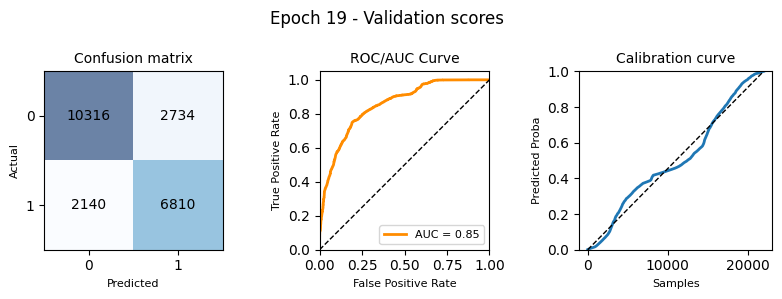

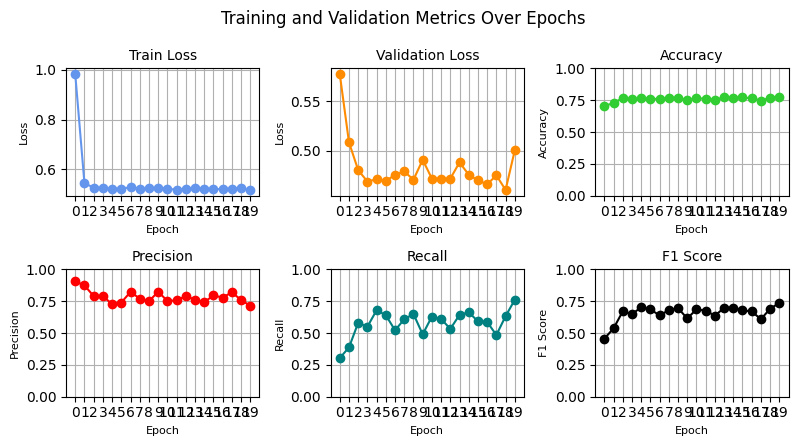

In [9]:
batch_size = 200

train_loader = DataLoader(hetero_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 32,
        "input_neuron_num": 64,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.5,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 4,
        "input_neuron_num": 32,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.2,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1,
        "input_neuron_num": 4,
        "activation_function": None
    },
]

model = HeterogeneousGNN(player_dims=[20, 5], map_dims=[15, 10, 5, 5, 3], dense_layers=dense_layers).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-2, weight_decay=0.05)
loss_function = torch.nn.BCEWithLogitsLoss()

# Initialization
with torch.no_grad():
    for batch in train_loader:
        batch = batch.to('cuda')
        out = model(batch.x_dict, batch.edge_index_dict, batch.y, batch_size)
        break
print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

train(model, train_loader, val_loader, batch_size, epochs=20)

In [10]:
# Initialize hetero_data list
test_data = torch.load(PATH_GRAPH_DATA + '100080.pt', weights_only=False)
test_data_index = 100081

for idx in range(3):
    temp = torch.load(PATH_GRAPH_DATA + str(test_data_index + idx) + '.pt', weights_only=False)
    test_data = test_data + temp

# Shuffle the data
np.random.shuffle(test_data)

-------------------------------------------------------------------------------------------
                                      Test Results
-------------------------------------------------------------------------------------------
Average loss: 0.5318222215229814 
Accuracy: 0.7294090909090909 
Precision: 0.7186266094420601 
Recall: 0.7578528107178419 
F1: 0.7377186412301185 
Confusion matrix & ROC/AUC
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



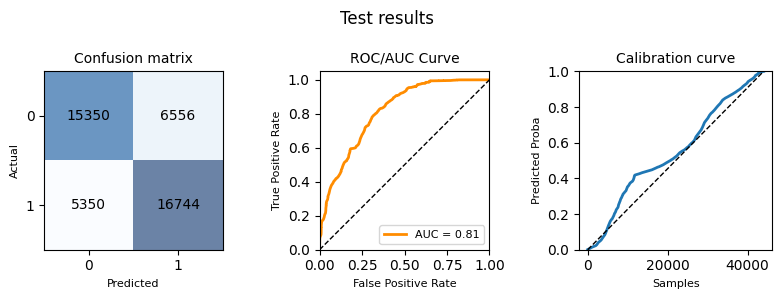

In [11]:
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

test(test_loader, batch_size)

In [12]:
torch.save(model, PATH_MODELS + '/240923_1/hetero_gnn_240923_1.pt')

# Testing the best models

In [108]:
model = torch.load(PATH_MODELS + '/240923_1/hetero_gnn_240923_1.pt', weights_only=False)

data  = torch.load(PATH_GRAPH_DATA + '100095.pt', weights_only=False)

In [109]:
rounds = []

# Select the graphs in round 5
for graph in data:
    if graph.y['round'] not in rounds:
        rounds.append(graph.y['round'])

rounds

[0.041666668,
 0.083333336,
 0.125,
 0.16666667,
 0.20833333,
 0.25,
 0.29166666,
 0.33333334,
 0.375,
 0.41666666,
 0.45833334,
 0.5,
 0.5416667,
 0.5833333,
 0.625,
 0.6666667,
 0.7083333,
 0.75]

In [110]:
selected_round = []

# Select round 5
for graph in data:
    round_rounded = round(graph.y['round'], 2)
    if round_rounded == np.float32(0.29):
        selected_round.append(graph)

len(selected_round)

482

In [111]:
# Give the round_five list to a DataLoader and then use the model to predict the outcome of the matches
selected_round_loader = DataLoader(selected_round, batch_size=1, shuffle=False)

model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data in selected_round_loader:
        data = data.to('cuda')
        out = model(data.x_dict, data.edge_index_dict, data.y, 1).float()
        target = torch.tensor(data.y['CT_wins']).float().to('cuda')
        predictions.append(torch.sigmoid(out).float().cpu().numpy())
        targets.append(target.cpu().numpy())

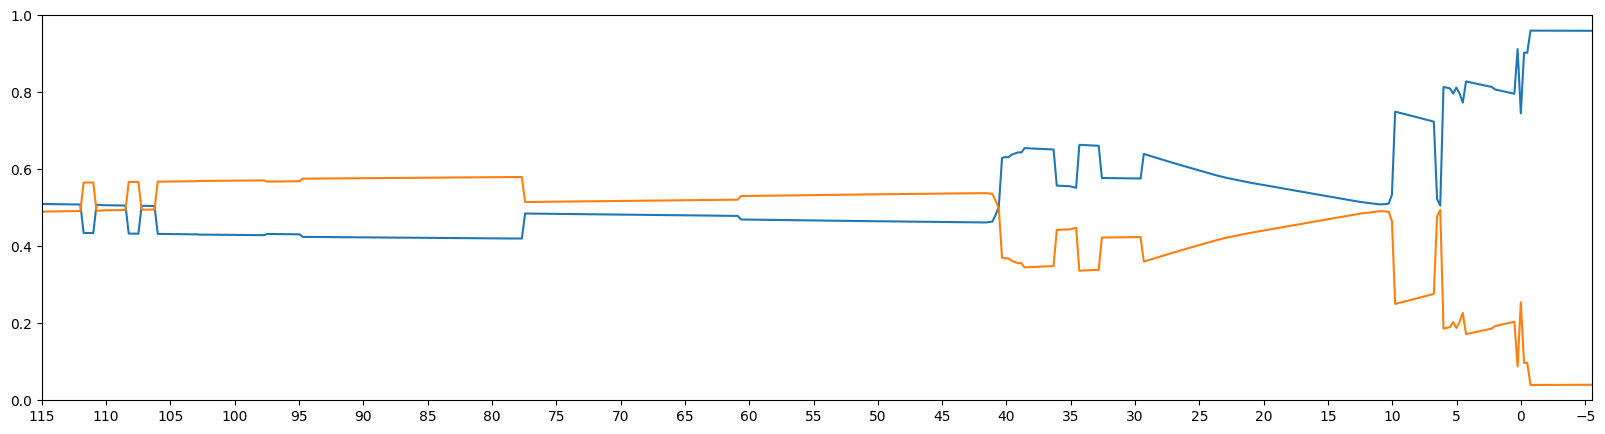

In [112]:
pred = [pred[0][0] for pred in predictions]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(115 - np.linspace(0, len(selected_round)/4, len(pred)), pred)
plt.plot(115 - np.linspace(0, len(selected_round)/4, len(pred)), 1 - np.array(pred))
plt.xticks(np.arange(-50, len(selected_round)/4, 5))
plt.ylim(0, 1);
plt.xlim(115 - len(selected_round)/4, 115);
plt.gca().invert_xaxis()